# Predicting Review Attributes Through Yelp Review Text
# By: Reilly Proudsworth

## The goal of this project is to find out if Yelp review attributes (star rating, coolness, hotness, etc.) can be predicted through the text left by a user.

In [52]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

The reviews are stored in json format which is too large for a single import using pd.read_json(), they needed to be extracted into a less memory intensive format for Pandas to read such as csv.  This task was taken care of in a seperate notebook for both efficient memory usage and tidiness.

In [2]:
df = pd.read_csv("yelp_text_reviews.csv", index_col=0, encoding='iso-8859-1')
df.head()

C:\Users\Reilly Proudsworth\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,business_id,cool,date,funny,review_id,stars,text,type,useful,user_id
0,2aFiy99vNLklCx3T_tGS9A,0,2011-10-10,0.0,NxL8SIC5yqOdnlXCg18IBg,5.0,If you enjoy service by someone who is as comp...,review,0.0,KpkOkG6RIf4Ra25Lhhxf1A
1,2aFiy99vNLklCx3T_tGS9A,0,2010-12-29,0.0,pXbbIgOXvLuTi_SPs1hQEQ,5.0,After being on the phone with Verizon Wireless...,review,1.0,bQ7fQq1otn9hKX-gXRsrgA
2,2aFiy99vNLklCx3T_tGS9A,0,2011-04-29,0.0,wslW2Lu4NYylb1jEapAGsw,5.0,Great service! Corey is very service oriented....,review,0.0,r1NUhdNmL6yU9Bn-Yx6FTw
3,2LfIuF3_sX6uwe-IR-P0jQ,1,2014-07-14,0.0,GP6YEearUWrzPtQYSF1vVg,5.0,Highly recommended. Went in yesterday looking ...,review,0.0,aW3ix1KNZAvoM8q-WghA3Q
4,2LfIuF3_sX6uwe-IR-P0jQ,0,2014-01-15,0.0,25RlYGq2s5qShi-pn3ufVA,4.0,I walked in here looking for a specific piece ...,review,0.0,YOo-Cip8HqvKp_p9nEGphw


Some statistics about our data frame:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4153151 entries, 0 to 4153149
Data columns (total 10 columns):
business_id    object
cool           int64
date           object
funny          float64
review_id      object
stars          float64
text           object
type           object
useful         float64
user_id        object
dtypes: float64(3), int64(1), object(6)
memory usage: 348.5+ MB


In [4]:
df.describe()

,cool,funny,stars,useful
count,4.153151e+06,4.153150e+06,4.153150e+06,4.153149e+06
mean,5.262231e-01,4.194826e-01,3.722765e+00,1.008271e+00
std,1.914350e+00,1.721744e+00,1.405131e+00,2.585058e+00
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,5.000000e+00,1.000000e+00
max,5.130000e+02,6.320000e+02,5.000000e+00,1.125000e+03


In [5]:
df.describe(include=['O'])

,business_id,date,review_id,text,type,user_id
count,4153151,4153151,4153150,4153149,4153149,4153149
unique,144073,4222,4153150,4150657,1,1029432
top,4JNXUYY8wbaaDmk3BPzlWw,2016-02-15,wGMJ3KXWO92BZXenbkL3AA,"Dear Sir, \nDo you need high quality custom em...",review,CxDOIDnH8gp9KXzpBHJYXw
freq,6414,3632,1,11,4153149,3327


We can see a few interesting elements show up here such as identical reviews being left (possibly bots or advertising), and that we might have a few blank rows (the count of 'type' doesn't equal the count of 'date').  Also one user_id has left over 3000 reviews!

We will explore the missing data and see how we should handle it.

In [6]:
null_mask = df['user_id'].isnull()
df[null_mask]

,business_id,cool,date,funny,review_id,stars,text,type,useful,user_id
1902097,uWECX6-Uq9n8v5ipk9R29A,1,2014-06-10,0.0,lyNSICzFzDPHXL_E6PHvWw,5.0,Best Creole/Cajun food in Nevada! Order the B...,NaN,NaN,NaN
All the goodness of the deep South! Seasoned and pan bronzed. Mississippi catfish served over Gouda grits with an andouille sausage and mushroom ragout.,review,0,aZs_IrhA7rvuLBumVhJjCw,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Clearly these rows are missing some data.  Let's see if removing them solves fixes the discrepancy between number of rows and count of reviews.

In [7]:
fix_df = df[~null_mask]
fix_df.describe(include=['O'])

,business_id,date,review_id,text,type,user_id
count,4153149,4153149,4153149,4153148,4153149,4153149
unique,144072,4221,4153149,4150656,1,1029432
top,4JNXUYY8wbaaDmk3BPzlWw,2016-02-15,wGMJ3KXWO92BZXenbkL3AA,"Dear Sir, \nDo you need high quality custom em...",review,CxDOIDnH8gp9KXzpBHJYXw
freq,6414,3632,1,11,4153149,3327


In [8]:
fix_df.describe()

,cool,funny,stars,useful
count,4.153149e+06,4.153149e+06,4.153149e+06,4.153149e+06
mean,5.262231e-01,4.194827e-01,3.722764e+00,1.008271e+00
std,1.914351e+00,1.721745e+00,1.405131e+00,2.585058e+00
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,5.000000e+00,1.000000e+00
max,5.130000e+02,6.320000e+02,5.000000e+00,1.125000e+03


The stats show one last row with an empty text field.

In [9]:
null_mask = fix_df['text'].isnull()
fix_df[null_mask]

,business_id,cool,date,funny,review_id,stars,text,type,useful,user_id
3528529,QTLrs-5SHUy1AnxydyI6zg,0,2013-10-07,1.0,md4LkUwmxSb5fEd_LTh6Kg,4.0,NaN,review,0.0,0i0kq07veTtdbRaOABEGiA


In [10]:
df = fix_df[~null_mask]

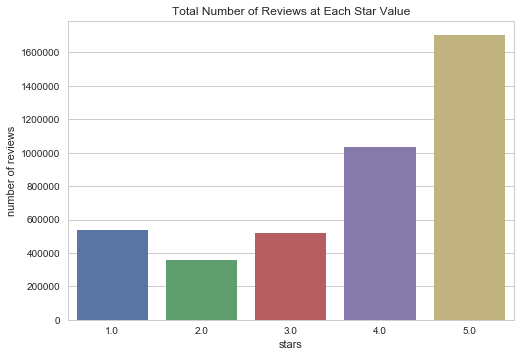

In [33]:
sns.set_style("whitegrid")

temp = df['stars'].value_counts(sort=False).head(30)
plot_df = pd.DataFrame({'stars':temp.index, 'number_of_reviews':temp.values})
ax = sns.barplot(x='stars', y='number_of_reviews', data=plot_df)
ax.set(title='Total Number of Reviews at Each Star Value', xlabel='stars', ylabel='number of reviews')
plt.show()

In [38]:
plot_df = []

In [12]:
## Join other data sets.

Eliminating 3 rows of data out of 4 million isn't too bad, so we'll progress with the analysis and training.  The next step is to explore the cleaned data.  In our description of the dataframe we see that the 'text' feature has some repeated entries.  What do these entries say?

In [14]:
temp = df['text'].value_counts().head(30)
review_df = pd.DataFrame({'Review_text':temp.index, 'number_of_repetitions':temp.values})
review_df.head(10)

,Review_text,number_of_repetitions
0,"Dear Sir, \nDo you need high quality custom em...",11
1,Good stuff,10
2,Your review helps others learn about great loc...,9
3,CUSTOMER SERVICE LINE WAS THE WORST PEOPLE IVE...,9
4,Update on how terrible this delivery service i...,9
5,"I am about to be a ""former"" Premier customer w...",8
6,"Dear Sir, \nDo you need high quality custom em...",7
7,r.i.p.,7
8,good stuff,6
9,I love Oregano's and they seem to know how to ...,6


We can see in rows 0/6 and 1/8 that the text appears to be almost completely identical but with slight differences which breaks them out into their own rows.  The temptation is to remove the duplicates in order to avoid biasing our model, however we can't assume that the repeated reviews are all left by the same person.  Considering there are only about 3000 repeated text boxes out of 4 million, it may not be worth solving the problem.  Good to identify for future improvement.

Next step is vectorizing the words and running through machine learning algorithms.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

Machine learning models can't 'read' the way humans can, but they're very good at dealing with numbers.  This means we need a tool which converts words to numbers.  There are a few out there, the most basic is one which 'reads' a review and counts the number of times a word appears in that document.  The result is a vector where the columns represent individual words and the number in that column is the count of times that word appeared.

We also seperate out the stars left for each review which is what we aim to predict with our model.

In [12]:
vectorizer = CountVectorizer()

In [13]:
y = df.stars.values.astype(np.int)

We next create the corpus of words that our vectorizor will use as a basis for counting, then the text is run through that counting process.

In [15]:
vectorizer.fit(df.text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [16]:
X = vectorizer.transform(df.text)

The data needs to be split into training and test sets.  The training set will be used to train the model while the test set is reserved for the end.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train.shape

(3322518, 647595)

In [19]:
y_train.shape

(3322518,)

The first model we'll try is a Naive Bayes model which tries to classify a review into a star category based on the words present in the document.  The first step is fitting the model onto the training data then the model attempts to predict the values of our test set.

In [23]:
mnb = MultinomialNB()
mnb

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [24]:
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)

The accuracy of our model can be appraised by looking at the score.  It's troubling that the accuracy of our training set is so low, it seems like it could be higher.  This could be indiciative of there being words which 'confuse' the model.  We might be able to tune the model to ignore some of those words and improve the accuracy.

Fortunately both the training and test sets are close in their accuracy.  Once the training set is tuned, hopefully the test set will have improved accuracy as well. 

In [22]:
print(mnb.score(X_train, y_train))
print(mnb.score(X_test, y_test))

0.596589694924
0.582851570495


The confusion matrix below shows how the model predicted vs. the true values.  The rows/columns relate to star ratings, with the true values as rows and predicted values as columns.  The number is the count of times a prediction was made at a value and what it's actual value should be.  This means that the diagonal represents correct predictions.

In [25]:
confusion_matrix(y_test, y_pred)

array([[ 73912,  23725,   6523,   2127,   1839],
       [ 17255,  23487,  22621,   5939,   2038],
       [  8632,  12564,  41046,  35077,   5793],
       [  7621,   5378,  21830, 126329,  45487],
       [ 18098,   2464,   5488,  95997, 219360]])

In [46]:
doc_count, word_count = X_train.shape
count_array = np.zeros(word_count)
X_train.shape

(3322518, 647595)

In [53]:
for review in tqdm_notebook(range(doc_count)):
    array = X_train[review].toarray()
    
    for word in range(word_count):
        if array[0][word] > 0:
            count_array[word] = count_array[word] + 1




Exception ignored in: <bound method tqdm.__del__ of   0%|                                                                      | 173/3322518 [39:28<12635:29:31, 13.69s/it]>
Traceback (most recent call last):
  File "C:\Users\Reilly Proudsworth\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 879, in __del__
    self.close()
  File "C:\Users\Reilly Proudsworth\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 1084, in close
    self._decr_instances(self)
  File "C:\Users\Reilly Proudsworth\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 452, in _decr_instances
    cls.monitor.exit()
  File "C:\Users\Reilly Proudsworth\Anaconda3\lib\site-packages\tqdm\_monitor.py", line 50, in exit
    self.join()
  File "C:\Users\Reilly Proudsworth\Anaconda3\lib\threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


KeyboardInterrupt: 